### Config

In [1]:
import os
from google.colab import drive
import numpy as np

# connect the google drive
drive.mount('/content/drive')
# paths, parameters
PATH = 'drive/MyDrive/Colab_Notebooks_2/mlits_project'
PATH_DATA = os.path.join(PATH, 'data')
PATH_MODELS = os.path.join(PATH, 'models')
PATH_ASSETS = os.path.join(PATH, 'assets')

np.random.seed(seed=42)

# create the subdirectories
!mkdir -p $PATH_DATA
!mkdir -p $PATH_MODELS
!mkdir -p $PATH_ASSETS

Mounted at /content/drive


In [ ]:
# unzip the data
!unzip -o $PATH_DATA'/*'
!mv tree_test.h5 $PATH_DATA
!mv tree_train.h5 $PATH_DATA

In [19]:
# install all needed libraries
!pip install -r $PATH'/requirements.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.9 MB/s eta 0:00:00


### Get data

In [ ]:
import h5py

# load the data to numpy arrays
train = h5py.File(os.path.join(PATH_DATA, 'tree_train.h5'), 'r')
test = h5py.File(os.path.join(PATH_DATA, 'tree_test.h5'), 'r')
X = np.array(train['X'])
y = np.array(train['y'])
X_test = np.array(test['X'])

In [ ]:
from sklearn.model_selection import train_test_split

# the test set does not have labels - I will create my own to compare single models
# create train, validation and test split - 0.6, 0.2, 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.40, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

### Visualize data

In [2]:
# imports
import matplotlib.pyplot as plt

def display(display_list):
    #plt.figure(figsize=(15, 15))

    if len(display_list) == 3:
        title = ["Input Image", "True Mask", "Prediction"]
    else:
        title = ["Input Image", "True Mask", "U-net", "U-net small", "VGG-backbone", "SegFormer"]

    for i in range(len(display_list)):
        if len(display_list) > 5:
            plt.subplot(2, int(round(len(display_list)/2)), i + 1)
        else:
            plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis("off")
    plt.show()

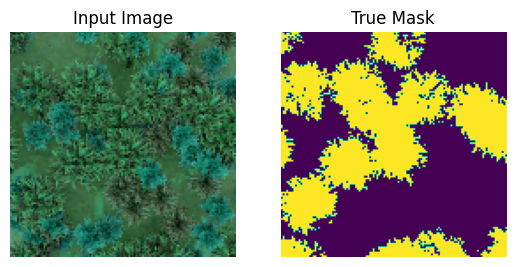

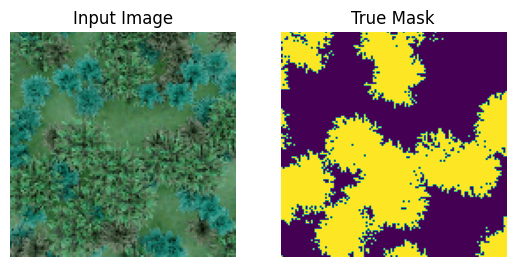

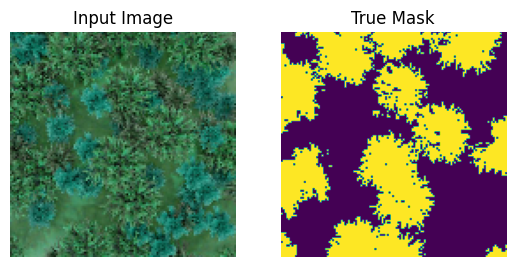

In [ ]:
# display some samples
n_images = 3
for _ in range(n_images):
  randint = np.random.randint(0, X_train.shape[0])
  display([X_train[randint], y_train[randint]])


The images are taken from the approximately the same height, but in slightly varying light conditions. The meaning of the pictures is not changed after rotation or flipping. <br>Therefore we will apply following data augmentation techniques:<br>1. Random rotation<br>2. Horizontal and vertical flipping<br>3. Random change of brightness and contrast<br>4. Diagonal, horizontal and vertical reflection

### Data augmentation

In [3]:
import albumentations as A
from tqdm.notebook import tqdm

In [4]:
# initialize the augmentor
# use combination several types with augmentation
aug = A.Compose(
    [
      A.VerticalFlip(p=0.5),
      A.HorizontalFlip(p=0.5),
      A.RandomRotate90(p=0.5),
      A.Transpose(p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.5),
    ]
)

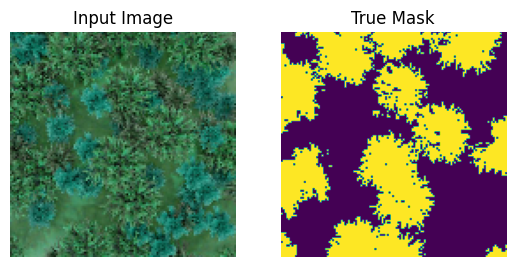

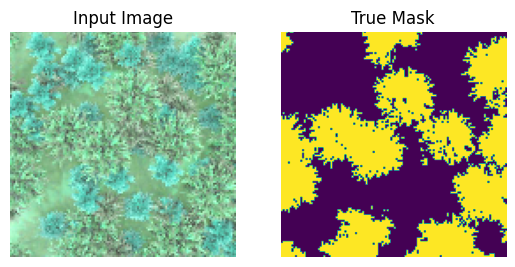

In [ ]:
# plot an example of the augmentation
augmented = aug(image=X_train[randint], mask=y_train[randint])
display([X_train[randint], y_train[randint]])
display([augmented['image'], augmented['mask']])

In [ ]:
# augment the training set, leave validation set unaugmented to have correct metrics when tuning hyper-parameters
for image, mask in tqdm(zip(X_train, y_train), total=len(X_train)):
  augmented = aug(image=image, mask=mask)
  X_train = np.concatenate((X_train, np.expand_dims(augmented['image'], axis=0)), axis=0)
  y_train = np.concatenate((y_train, np.expand_dims(augmented['mask'], axis=0)), axis=0)

  0%|          | 0/2400 [00:00<?, ?it/s]

In [ ]:
# save the augmented training set
train_aug = h5py.File(os.path.join(PATH_DATA, 'tree_train_aug.h5'), 'w')
Xset = train_aug.create_dataset("X", data=X_train)
yset = train_aug.create_dataset("y", data=y_train)

# save the validation set
val_aug = h5py.File(os.path.join(PATH_DATA, 'tree_val.h5'), 'w')
Xvset = val_aug.create_dataset("X", data=X_val)
yvset = val_aug.create_dataset("y", data=y_val)

# save our test set
test = h5py.File(os.path.join(PATH_DATA, 'tree_test_dev.h5'), 'w')
Xtset = test.create_dataset("X", data=X_test)
ytset = test.create_dataset("y", data=y_test)

In [12]:
import h5py

# function to load and normalize all the preprocessed data
# so that we don't have to do the splitting and augmentation every single time
# and all models are trained on the exactly same data
def load_data(normalize=True):
    train = h5py.File(os.path.join(PATH_DATA, 'tree_train_aug.h5'), 'r')
    X_train = np.array(train['X'])
    y_train = np.array(train['y'])
    val = h5py.File(os.path.join(PATH_DATA, 'tree_val.h5'), 'r')
    X_val = np.array(val['X'])
    y_val = np.array(val['y'])
    test = h5py.File(os.path.join(PATH_DATA, 'tree_test_dev.h5'), 'r')
    X_test = np.array(test['X'])
    y_test = np.array(test['y'])
    test_no = h5py.File(os.path.join(PATH_DATA, 'tree_test.h5'), 'r')
    X_test_no = np.array(test_no['X'])
    # normalize
    if normalize:
        X_train = X_train / 255
        X_val = X_val / 255
        X_test = X_test / 255
        X_test_no = X_test_no / 255
    return X_train, y_train, X_val, y_val, X_test, y_test, X_test_no

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test, X_test_no = load_data()

### Models

#### U-net - trained from scratch

In [3]:
# imports
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, LeakyReLU
from tensorflow.keras.models import Model
import pandas as pd

In [4]:
# define the U-net model
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [5]:
# implementing the dice loss function and f1 metric
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tf.cast(true_positives, dtype='float64') / (tf.cast(predicted_positives, dtype='float64') + K.epsilon())
    recall = tf.cast(true_positives, dtype='float64') / (tf.cast(possible_positives, dtype='float64') + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# define hyperparameters space
filters = [8, 16, 24, 32, 48]
dropouts = [0, 0.2, 0.4]
learning_rates = [0.005, 0.001, 0.0005]

In [14]:
# saving the training info fr every hyperparam combination to separate file
input_img = Input(shape=X_train.shape[1:])
if os.path.exists(os.path.join(PATH, 'assets', 'grid_search_results.csv')):
  df = pd.read_csv(os.path.join(PATH, 'assets', 'grid_search_results.csv'), index_col=0)
else:
  df = pd.DataFrame(
    columns=[
      'filters', 'dropout', 'learning_rate', 'n_epochs', 'val_loss',
        'val_accuracy', 'val_iou', 'val_f1'
        ]
    )

In [ ]:
# grid search
for filter in filters:
  for dropout in dropouts:
    for learning_rate in learning_rates:

      # free the RAM
      K.clear_session()

      # initialize model
      model = get_unet(
        input_img,
        n_filters = filter,
        dropout = dropout,
        batchnorm = True,
        n_classes = 1
      )
      adam = Adam(learning_rate=learning_rate)

      # compile and fit the model
      model.compile(optimizer=adam, loss=DiceLoss(), metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,])
      history = model.fit(X_train, y_train, epochs=12, validation_data=(X_val, y_val), verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights=True)])

      # extract all the training information
      n_epochs = np.argmax(pd.DataFrame(history.history).val_binary_io_u)
      hist = pd.DataFrame(history.history)
      eval = list(hist.iloc[np.argmax(hist.val_binary_io_u)][['val_loss', 'val_accuracy', 'val_binary_io_u', 'val_get_f1']])
      df = pd.concat([df, pd.DataFrame([[filter, dropout, learning_rate, n_epochs, *eval]], columns=df.columns)], axis=0)

      # save after every iteration
      df.to_csv(os.path.join(PATH, 'assets', 'grid_search_results.csv'))
      save_path = os.path.join(
          PATH,
          'models',
          'unet_' + str(filter) + '_' + str(dropout) + '_' + str(learning_rate) + '_' + str(n_epochs)
          )
      model.save(save_path)


In [ ]:
# extract the best hyperparameters
best_params = df.iloc[np.argmax(df.val_iou),:]

In [ ]:
# retrain the best model on all data and save it
model = get_unet(
        input_img,
        n_filters = best_params.filters,
        dropout = best_params.dropout,
        batchnorm = True,
        n_classes = 1
      )
adam = Adam(learning_rate=best_params.learning_rate)
model.compile(
    optimizer=adam,
    loss=DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,]
    )

# train for longer to find out the best number of epochs
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    verbose=1,
)

# save the model
model.save(os.path.join(PATH, 'models', 'u_net_tuned_50'))

# save the training info
pd.DataFrame(history.history).to_csv(os.path.join(PATH, 'assets', 'u_net_tuned_50_training.csv'))

# get the optimal number of epochs
best_n_epochs = np.argmax(pd.DataFrame(history.history).val_binary_io_u)+1

Epoch 1/50
150/150 [==============================] - 92s 355ms/step - loss: 0.0935 - accuracy: 0.8907 - binary_io_u: 0.8020 - get_f1: 0.8820 - val_loss: 0.5068 - val_accuracy: 0.6009 - val_binary_io_u: 0.3526 - val_get_f1: 0.2290
Epoch 2/50
150/150 [==============================] - 55s 369ms/step - loss: 0.0654 - accuracy: 0.9231 - binary_io_u: 0.8564 - get_f1: 0.9162 - val_loss: 0.0774 - val_accuracy: 0.9126 - val_binary_io_u: 0.8374 - val_get_f1: 0.9012
Epoch 3/50
150/150 [==============================] - 55s 368ms/step - loss: 0.0597 - accuracy: 0.9294 - binary_io_u: 0.8673 - get_f1: 0.9230 - val_loss: 0.0551 - val_accuracy: 0.9352 - val_binary_io_u: 0.8775 - val_get_f1: 0.9290
Epoch 4/50
150/150 [==============================] - 55s 369ms/step - loss: 0.0552 - accuracy: 0.9344 - binary_io_u: 0.8761 - get_f1: 0.9283 - val_loss: 0.0493 - val_accuracy: 0.9420 - val_binary_io_u: 0.8896 - val_get_f1: 0.9366
Epoch 5/50
150/150 [==============================] - 53s 353ms/step - loss:

In [ ]:
# load the training history
train_hist = pd.read_csv(os.path.join(PATH, 'assets', 'u_net_tuned_50_training.csv'))

In [7]:
# function for plotting the learning curves
def plot_training(train_hist, validation=True):
  if validation:
      # plot the training
      plt.plot(train_hist['binary_io_u'])
      plt.plot(train_hist['val_binary_io_u'])
      plt.title('Metrics')
      plt.ylabel('IoU')
      plt.xlabel('Epoch')
      plt.legend(['Training', 'Validation'], loc='upper left')
      plt.show()

      plt.plot(train_hist['loss'])
      plt.plot(train_hist['val_loss'])
      plt.title('Loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Training', 'Validation'], loc='upper left')
      plt.show()
  else:
      # plot the training
      plt.plot(history.history['binary_io_u'])
      plt.plot(history.history['get_f1'])
      plt.title('Training metrics')
      plt.ylabel('Metrics')
      plt.xlabel('Epoch')
      plt.legend(['IoU', 'F1-score'], loc='upper left')
      plt.show()

      plt.plot(history.history['loss'])
      plt.title('Training loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.show()

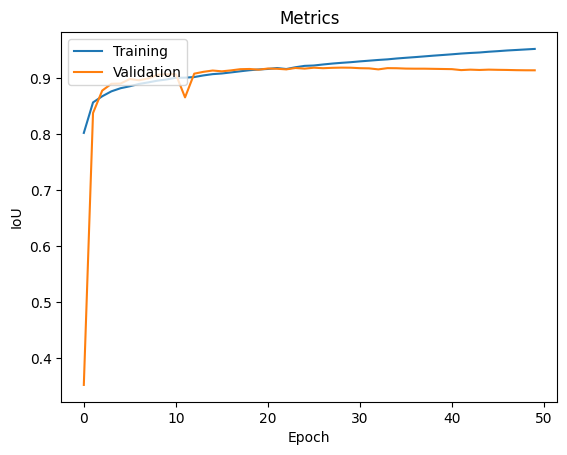

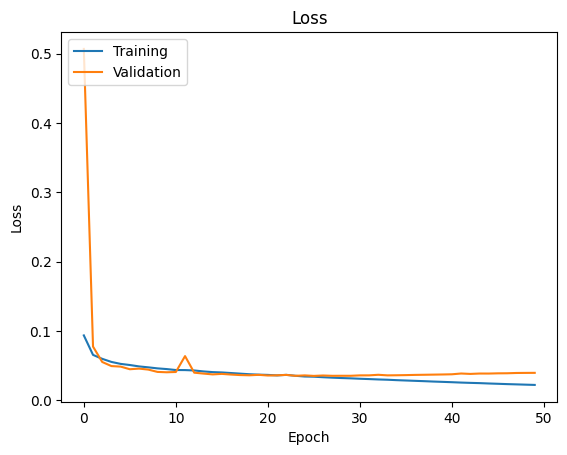

In [ ]:
plot_training(train_hist, validation=True)

In [ ]:
# extract the best number of epochs
best_n_epochs = np.argmax(train_hist.val_binary_io_u)+1

In [ ]:
# merge train and val data, augment the val data as well to retrain the model on as much data as possible

# prepare empty vectors for the augmented data
X_val_aug = np.empty((0,128,128,3))
y_val_aug = np.empty((0,128,128,1))

# reload validation data
# because we need them unnormalized for the augmentation
val = h5py.File(os.path.join(PATH_DATA, 'tree_val.h5'), 'r')
X_val = np.array(val['X'])
y_val = np.array(val['y'])

# use the same augmentator that was initialized for the training data
for image, mask in tqdm(zip(X_val, y_val), total=len(X_val)):
  augmented = aug(image=image, mask=mask)
  X_val_aug = np.concatenate((X_val_aug, np.expand_dims(augmented['image'], axis=0)), axis=0)
  y_val_aug = np.concatenate((y_val_aug, np.expand_dims(augmented['mask'], axis=0)), axis=0)

# normalize
X_val = X_val / 255
X_val_aug = X_val_aug / 255

# concatenate all the available data
X_all = np.concatenate((X_train, X_val_aug, X_val), axis=0)
y_all = np.concatenate((y_train, y_val_aug, y_val), axis=0)

  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
# retrain the best model on all data and save it
best_params = df.iloc[np.argmax(df.val_iou),:]

# initialize, compile, fit, save
model = get_unet(
        input_img,
        n_filters = best_params.filters,
        dropout = best_params.dropout,
        batchnorm = True,
        n_classes = 1
      )
adam = Adam(learning_rate=best_params.learning_rate)
model.compile(
    optimizer=adam,
    loss=DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,]
    )

history = model.fit(
    X_all, y_all,
    epochs=best_n_epochs,
    verbose=1,
)
model.save(os.path.join(PATH, 'models', 'u_net_tuned'))

Epoch 1/29
200/200 [==============================] - 101s 323ms/step - loss: 0.0852 - accuracy: 0.8974 - binary_io_u: 0.8132 - get_f1: 0.8927
Epoch 2/29
200/200 [==============================] - 66s 331ms/step - loss: 0.0608 - accuracy: 0.9280 - binary_io_u: 0.8649 - get_f1: 0.9215
Epoch 3/29
200/200 [==============================] - 67s 338ms/step - loss: 0.0549 - accuracy: 0.9347 - binary_io_u: 0.8766 - get_f1: 0.9287
Epoch 4/29
200/200 [==============================] - 69s 343ms/step - loss: 0.0513 - accuracy: 0.9387 - binary_io_u: 0.8838 - get_f1: 0.9330
Epoch 5/29
200/200 [==============================] - 69s 346ms/step - loss: 0.0493 - accuracy: 0.9411 - binary_io_u: 0.8880 - get_f1: 0.9355
Epoch 6/29
200/200 [==============================] - 70s 351ms/step - loss: 0.0470 - accuracy: 0.9438 - binary_io_u: 0.8928 - get_f1: 0.9385
Epoch 7/29
200/200 [==============================] - 70s 351ms/step - loss: 0.0455 - accuracy: 0.9455 - binary_io_u: 0.8958 - get_f1: 0.9402
Epoch

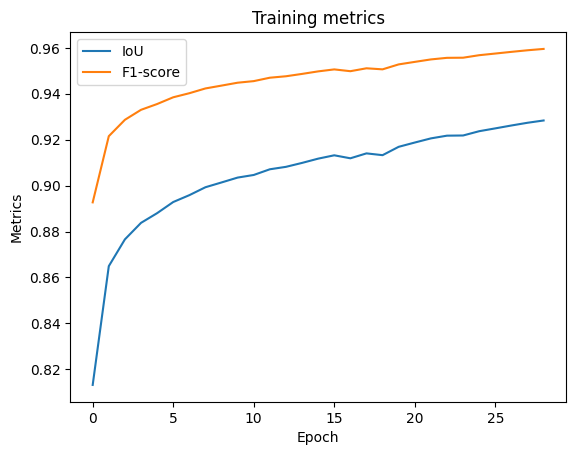

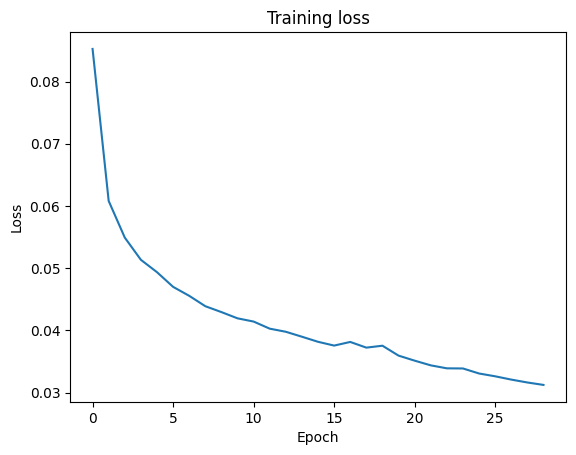

In [ ]:
plot_training(history.history, validation=False)

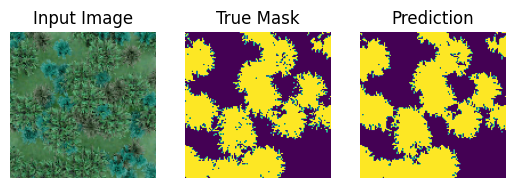

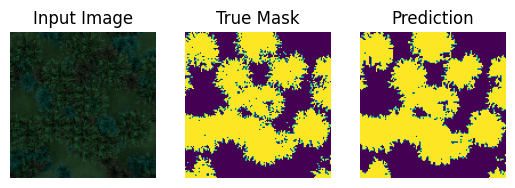

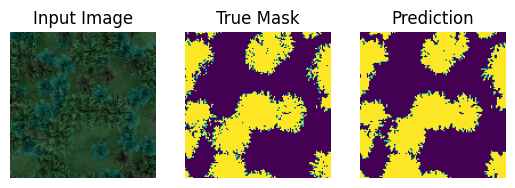

In [43]:
# display predictions on few samples from the test set
n_images = 3
for _ in range(n_images):
  randint = np.random.randint(0, X_test.shape[0])
  y_pred = model.predict(X_test[randint][None,:], verbose=0).round()
  display([X_test[randint], y_test[randint], y_pred[0]])

#### U-Net - small version

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, X_test_no = load_data()

In [ ]:
best_params = df.loc[df.filters==8].iloc[np.argmax(df.loc[df.filters==8].val_iou),:]

model = get_unet(
        input_img,
        n_filters = best_params.filters,
        dropout = best_params.dropout,
        batchnorm = True,
        n_classes = 1
      )
adam = Adam(learning_rate=best_params.learning_rate)
model.compile(
    optimizer=adam,
    loss=DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,]
    )

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    verbose=1,
)

pd.DataFrame(history.history).to_csv(os.path.join(PATH, 'assets', 'u_net_small_tuned_100_training.csv'))

Epoch 1/100
150/150 [==============================] - 26s 71ms/step - loss: 0.1096 - accuracy: 0.8724 - binary_io_u_1: 0.7729 - get_f1: 0.8648 - val_loss: 0.1761 - val_accuracy: 0.8001 - val_binary_io_u_1: 0.6587 - val_get_f1: 0.7549
Epoch 2/100
150/150 [==============================] - 9s 59ms/step - loss: 0.0733 - accuracy: 0.9134 - binary_io_u_1: 0.8397 - get_f1: 0.9058 - val_loss: 0.0901 - val_accuracy: 0.8914 - val_binary_io_u_1: 0.8038 - val_get_f1: 0.8861
Epoch 3/100
150/150 [==============================] - 9s 59ms/step - loss: 0.0680 - accuracy: 0.9196 - binary_io_u_1: 0.8503 - get_f1: 0.9123 - val_loss: 0.0642 - val_accuracy: 0.9260 - val_binary_io_u_1: 0.8611 - val_get_f1: 0.9178
Epoch 4/100
150/150 [==============================] - 9s 58ms/step - loss: 0.0628 - accuracy: 0.9258 - binary_io_u_1: 0.8610 - get_f1: 0.9191 - val_loss: 0.0621 - val_accuracy: 0.9290 - val_binary_io_u_1: 0.8660 - val_get_f1: 0.9201
Epoch 5/100
150/150 [==============================] - 9s 59ms/

AttributeError: ignored

In [ ]:
history_small_unet = pd.read_csv(os.path.join(PATH, 'assets', 'u_net_small_tuned_100_training.csv'))

In [ ]:
best_n_epochs = np.argmax(pd.DataFrame(history_small_unet).val_binary_io_u)+1

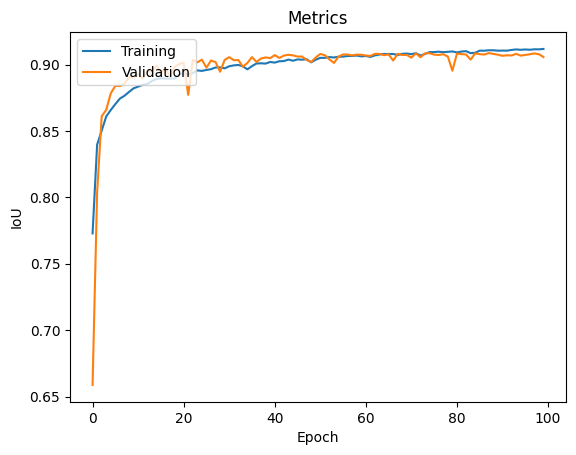

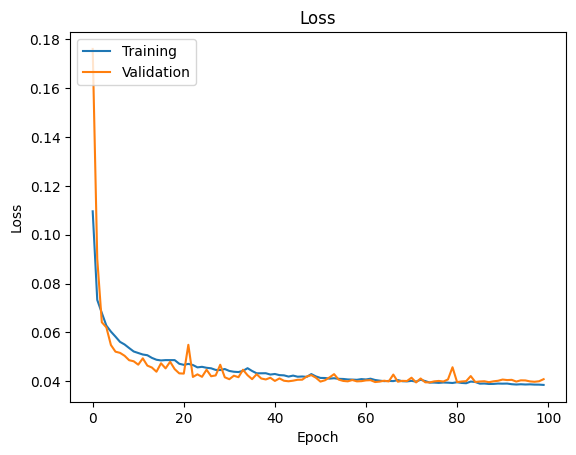

In [ ]:
plot_training(history_small_unet, validation=True)

In [ ]:
# merge train and val data, augment the val data as well
X_val_aug = np.empty((0,128,128,3))
y_val_aug = np.empty((0,128,128,1))

val = h5py.File(os.path.join(PATH_DATA, 'tree_val.h5'), 'r')
X_val = np.array(val['X'])
y_val = np.array(val['y'])

for image, mask in tqdm(zip(X_val, y_val), total=len(X_val)):
  augmented = aug(image=image, mask=mask)
  X_val_aug = np.concatenate((X_val_aug, np.expand_dims(augmented['image'], axis=0)), axis=0)
  y_val_aug = np.concatenate((y_val_aug, np.expand_dims(augmented['mask'], axis=0)), axis=0)

X_val = X_val / 255
X_val_aug = X_val_aug / 255

X_all = np.concatenate((X_train, X_val_aug, X_val), axis=0)
y_all = np.concatenate((y_train, y_val_aug, y_val), axis=0)

  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
# retrain the best model on all data and save it
best_params = df.loc[df.filters==8].iloc[np.argmax(df.loc[df.filters==8].val_iou),:]

model = get_unet(
        input_img,
        n_filters = best_params.filters,
        dropout = best_params.dropout,
        batchnorm = True,
        n_classes = 1
      )
adam = Adam(learning_rate=best_params.learning_rate)
model.compile(
    optimizer=adam,
    loss=DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,]
    )

history = model.fit(
    X_all, y_all,
    #epochs=best_n_epochs,
    epochs=2,
    verbose=1,
)
model.save_weights(os.path.join(PATH, 'models', 'u_net_small_tuned_test'))

Epoch 1/2
200/200 [==============================] - 25s 54ms/step - loss: 0.1045 - accuracy: 0.8770 - binary_io_u: 0.7802 - get_f1: 0.8700
Epoch 2/2
200/200 [==============================] - 10s 52ms/step - loss: 0.0705 - accuracy: 0.9166 - binary_io_u: 0.8452 - get_f1: 0.9095


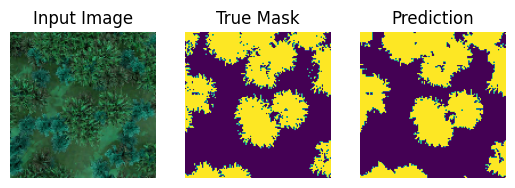

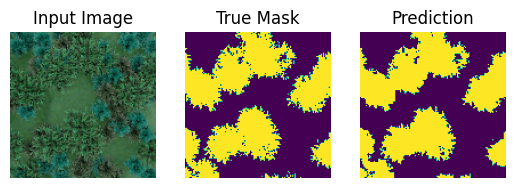

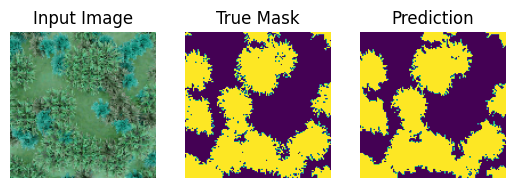

In [42]:
# display predictions on few samples from the test set
n_images = 3
for _ in range(n_images):
  randint = np.random.randint(0, X_test.shape[0])
  y_pred = model.predict(X_test[randint][None,:], verbose=0).round()
  display([X_test[randint], y_test[randint], y_pred[0]])

#### U-Net - transfer learning

In [8]:
from keras.applications import vgg16

In [9]:
def get_pretrained_u_net(input_shape=(128,128,3), n_classes=1):
    # get the pretrained encoder without final layer
    VGG16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    last_layer = VGG16.output

    # freeze the encoder layers
    for layer in VGG16.layers:
      layer.trainable = False

    # add the decoder part
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_1 = concatenate([model_,VGG16.get_layer("block5_conv3").output])

    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_2 = concatenate([model_,VGG16.get_layer("block4_conv3").output])

    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_3 = concatenate([model_,VGG16.get_layer("block3_conv3").output])

    model_ = Conv2D(256,(3,3),strides=(1, 1),padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_4 = concatenate([model_,VGG16.get_layer("block2_conv2").output])

    model_ = Conv2D(128,(3,3),strides=(1, 1),padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_5 = concatenate([model_,VGG16.get_layer("block1_conv2").output])

    model_ = Conv2D(64,(3,3),strides=(1, 1),padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(3,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(n_classes, (1, 1), activation='sigmoid')(model_)

    model_ = Model(VGG16.input,model_)

    return model_

In [ ]:
# reload the training data to have same conditions as for the previous training
X_train, y_train, X_val, y_val, X_test, y_test, X_test_no = load_data()

In [ ]:
# train the vgg16 based u-net
K.clear_session()
model_vgg = get_pretrained_u_net()
adam = Adam(learning_rate=best_params.learning_rate)
model_vgg.compile(
    optimizer=adam,
    loss=DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,]
    )

history = model_vgg.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights=True)]
    )

pd.DataFrame(history.history).to_csv(os.path.join(PATH, 'assets', 'u_net_vgg_training.csv'))

model_vgg.save(os.path.join(PATH, 'models', 'u_net_vgg'))

Epoch 1/50
150/150 [==============================] - 81s 474ms/step - loss: 0.0982 - accuracy: 0.8962 - binary_io_u: 0.8110 - get_f1: 0.8862 - val_loss: 0.0885 - val_accuracy: 0.9199 - val_binary_io_u: 0.8509 - val_get_f1: 0.9128
Epoch 2/50
150/150 [==============================] - 69s 463ms/step - loss: 0.0741 - accuracy: 0.9194 - binary_io_u: 0.8499 - get_f1: 0.9124 - val_loss: 0.0672 - val_accuracy: 0.9277 - val_binary_io_u: 0.8647 - val_get_f1: 0.9230
Epoch 3/50
150/150 [==============================] - 70s 468ms/step - loss: 0.0672 - accuracy: 0.9246 - binary_io_u: 0.8589 - get_f1: 0.9179 - val_loss: 0.0579 - val_accuracy: 0.9347 - val_binary_io_u: 0.8768 - val_get_f1: 0.9291
Epoch 4/50
150/150 [==============================] - 71s 470ms/step - loss: 0.0624 - accuracy: 0.9288 - binary_io_u: 0.8663 - get_f1: 0.9224 - val_loss: 0.0554 - val_accuracy: 0.9376 - val_binary_io_u: 0.8816 - val_get_f1: 0.9314
Epoch 5/50
150/150 [==============================] - 70s 469ms/step - loss:

In [ ]:
train_hist_vgg = pd.read_csv(os.path.join(PATH, 'assets', 'u_net_vgg_training.csv'))

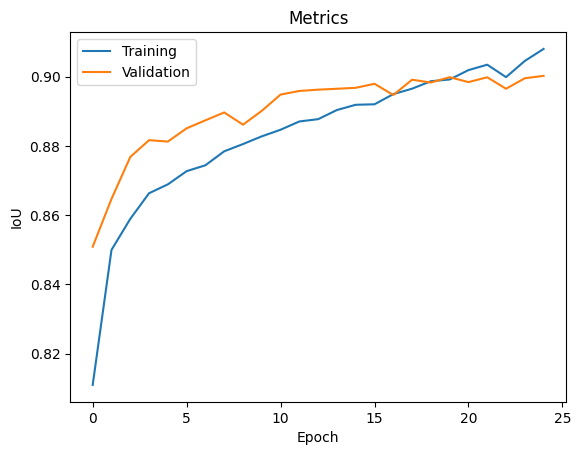

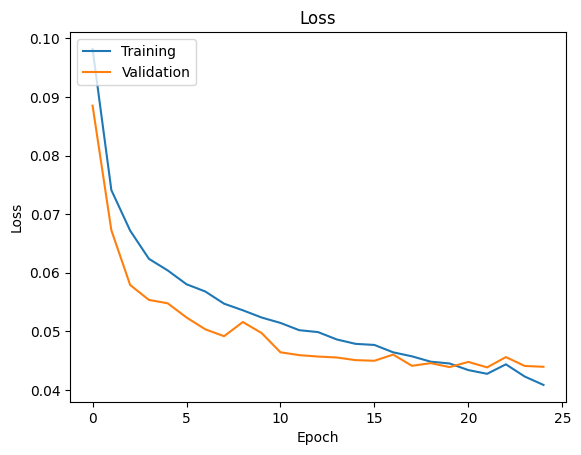

In [ ]:
# plot the training progress
plot_training(train_hist_vgg, validation=True)

In [ ]:
best_n_epochs = np.argmax(train_hist_vgg.val_binary_io_u)+1

In [ ]:
# merge train and val data, augment the val data as well
X_val_aug = np.empty((0,128,128,3))
y_val_aug = np.empty((0,128,128,1))

val = h5py.File(os.path.join(PATH_DATA, 'tree_val.h5'), 'r')
X_val = np.array(val['X'])
y_val = np.array(val['y'])

for image, mask in tqdm(zip(X_val, y_val), total=len(X_val)):
  augmented = aug(image=image, mask=mask)
  X_val_aug = np.concatenate((X_val_aug, np.expand_dims(augmented['image'], axis=0)), axis=0)
  y_val_aug = np.concatenate((y_val_aug, np.expand_dims(augmented['mask'], axis=0)), axis=0)

X_val = X_val / 255
X_val_aug = X_val_aug / 255

X_all = np.concatenate((X_train, X_val_aug, X_val), axis=0)
y_all = np.concatenate((y_train, y_val_aug, y_val), axis=0)

  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
# retrain the best model on all data and save it
best_params = df.iloc[np.argmax(df.val_iou),:]

model_vgg = get_pretrained_u_net()
adam = Adam(learning_rate=best_params.learning_rate)
model_vgg.compile(
    optimizer=adam,
    loss=DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,]
    )

history = model_vgg.fit(
    X_all, y_all,
    epochs=best_n_epochs,
    verbose=1,
)
model_vgg.save(os.path.join(PATH, 'models', 'u_net_vgg_tuned'))

Epoch 1/25
200/200 [==============================] - 118s 417ms/step - loss: 0.0988 - accuracy: 0.9016 - binary_io_u_1: 0.8200 - get_f1: 0.8939
Epoch 2/25
200/200 [==============================] - 87s 437ms/step - loss: 0.0739 - accuracy: 0.9218 - binary_io_u_1: 0.8542 - get_f1: 0.9149
Epoch 3/25
200/200 [==============================] - 87s 437ms/step - loss: 0.0663 - accuracy: 0.9264 - binary_io_u_1: 0.8620 - get_f1: 0.9198
Epoch 4/25
200/200 [==============================] - 88s 439ms/step - loss: 0.0618 - accuracy: 0.9297 - binary_io_u_1: 0.8678 - get_f1: 0.9233
Epoch 5/25
200/200 [==============================] - 88s 439ms/step - loss: 0.0583 - accuracy: 0.9326 - binary_io_u_1: 0.8729 - get_f1: 0.9265
Epoch 6/25
200/200 [==============================] - 87s 437ms/step - loss: 0.0564 - accuracy: 0.9340 - binary_io_u_1: 0.8755 - get_f1: 0.9280
Epoch 7/25
200/200 [==============================] - 87s 437ms/step - loss: 0.0549 - accuracy: 0.9355 - binary_io_u_1: 0.8781 - get_f1

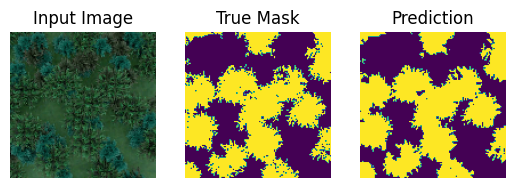

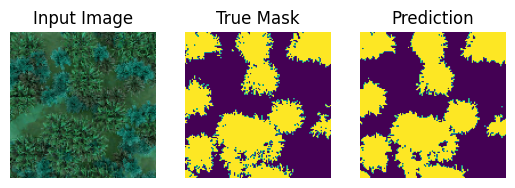

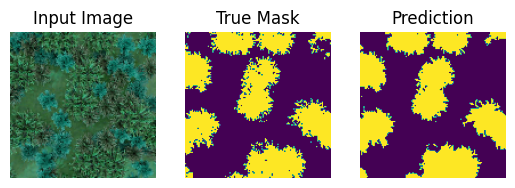

In [41]:
# display predictions on few samples from the test set
n_images = 3
for _ in range(n_images):
  randint = np.random.randint(0, X_test.shape[0])
  y_pred = model_vgg.predict(X_test[randint][None,:], verbose=0).round()
  display([X_test[randint], y_test[randint], y_pred[0]])

### SegFormer

In [10]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import TFSegformerForSemanticSegmentation

# load the pretrained transformer model and adjust it to our settings
model_checkpoint = "nvidia/segformer-b0-finetuned-ade-512-512"
id2label = {0: "no_tree", 1: "tree"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

Some weights of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head/classifier/kernel:0: found shape (1, 1, 256, 150) in the checkpoint and (1, 1, 256, 2) in the model instantiated
- decode_head/classifier/bias:0: found shape (150,) in the checkpoint and (2,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow import keras

# the model expects different size of the image
# create a function that loads and transforms the images
image_size = 512
def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )

    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

In [24]:
# create tensorflow datasets
train_data = tf.data.Dataset.from_tensor_slices({'image':X_train, 'segmentation_mask':y_train})
val_data = tf.data.Dataset.from_tensor_slices({'image':X_val, 'segmentation_mask':y_val})
test_data = tf.data.Dataset.from_tensor_slices({'image':X_test, 'segmentation_mask':y_test})

In [ ]:
auto = tf.data.AUTOTUNE
batch_size = 16

# load the images and apply the transformation
train_ds = (
    train_data
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)
val_ds = (
    val_data
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)
test_ds = (
    test_data
    .map(load_image, num_parallel_calls=auto)
    .batch(1)
    .prefetch(auto)
)

In [ ]:
# use the same learning rate as in paper
lr = 0.00006
adam = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(
    optimizer=adam,
    )

In [ ]:
K.clear_session()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=1,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(PATH, 'models', 'segformer_best'), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)]
)
model.save_weights(os.path.join(PATH, 'models', 'segformer'))

Epoch 1/3
2/2 [==============================] - 120s 64s/step - loss: 0.7722 - val_loss: 0.5604
Epoch 2/3
2/2 [==============================] - 135s 98s/step - loss: 0.6720 - val_loss: 0.4676
Epoch 3/3
2/2 [==============================] - 106s 63s/step - loss: 0.6252 - val_loss: 0.4698


In [ ]:
# save the training history
pd.DataFrame(history.history).to_csv(os.path.join(PATH, 'assets', 'segformer_training.csv'))

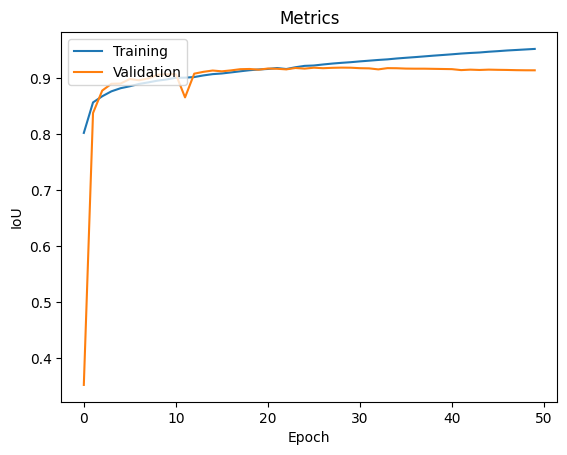

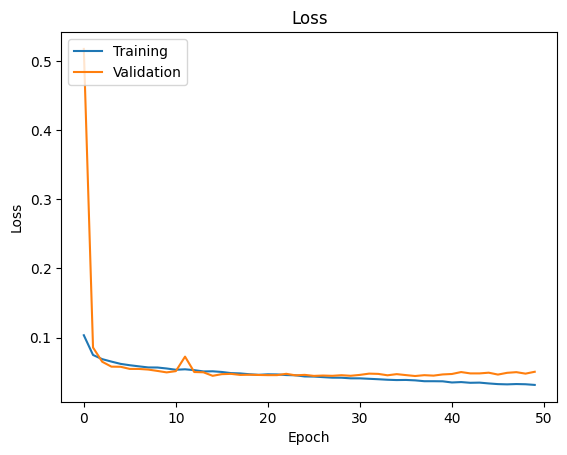

In [ ]:
plot_training(history.history, validation=True)

In [ ]:
best_n_epochs = np.argmax(history.history.val_binary_io_u)+1

In [12]:
best_n_epochs=21

In [13]:
# merge train and val data, augment the val data as well
X_val_aug = np.empty((0,128,128,3))
y_val_aug = np.empty((0,128,128,1))

val = h5py.File(os.path.join(PATH_DATA, 'tree_val.h5'), 'r')
X_val = np.array(val['X'])
y_val = np.array(val['y'])

for image, mask in tqdm(zip(X_val, y_val), total=len(X_val)):
  augmented = aug(image=image, mask=mask)
  X_val_aug = np.concatenate((X_val_aug, np.expand_dims(augmented['image'], axis=0)), axis=0)
  y_val_aug = np.concatenate((y_val_aug, np.expand_dims(augmented['mask'], axis=0)), axis=0)

X_val = X_val / 255
X_val_aug = X_val_aug / 255

X_all = np.concatenate((X_train, X_val_aug, X_val), axis=0)
y_all = np.concatenate((y_train, y_val_aug, y_val), axis=0)

  0%|          | 0/800 [00:00<?, ?it/s]

In [14]:
# free the RAM memory
del X_train, X_val_aug, X_val, y_train, y_val_aug, y_val

In [15]:
# create tensorflow dataset
all_data = tf.data.Dataset.from_tensor_slices({'image':X_all, 'segmentation_mask':y_all})
auto = tf.data.AUTOTUNE
batch_size = 16

# load the images and apply the transformation
all_ds = (
    all_data
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

In [16]:
# free the RAM memory
del X_all, y_all

In [17]:
# retrain the best model on all data and save it
from transformers import TFSegformerForSemanticSegmentation

# load the pretrained transformer model and adjust it to our settings
model_checkpoint = "nvidia/segformer-b0-finetuned-ade-512-512"
id2label = {0: "no_tree", 1: "tree"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

K.clear_session()
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
# use the same learning rate as in paper
lr = 0.00006
adam = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=adam)

history = model.fit(
    all_ds,
    epochs=best_n_epochs,
    verbose=1,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(PATH, 'models', 'segformer_best_tuned'), monitor='loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)]

)
model.save_weights(os.path.join(PATH, 'models', 'segformer_tuned'))
pd.DataFrame(history.history).to_csv(os.path.join(PATH, 'assets', 'segformer_tuned.csv'))

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

Some weights of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head/classifier/kernel:0: found shape (1, 1, 256, 150) in the checkpoint and (1, 1, 256, 2) in the model instantiated
- decode_head/classifier/bias:0: found shape (150,) in the checkpoint and (2,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/21
400/400 [==============================] - 424s 864ms/step - loss: 0.2207
Epoch 2/21
400/400 [==============================] - 346s 865ms/step - loss: 0.1769
Epoch 3/21
400/400 [==============================] - 346s 864ms/step - loss: 0.1678
Epoch 4/21
400/400 [==============================] - 346s 864ms/step - loss: 0.1629
Epoch 5/21
400/400 [==============================] - 346s 865ms/step - loss: 0.1594
Epoch 6/21
400/400 [==============================] - 346s 864ms/step - loss: 0.1569
Epoch 7/21
400/400 [==============================] - 346s 864ms/step - loss: 0.1547
Epoch 8/21
400/400 [==============================] - 345s 863ms/step - loss: 0.1530
Epoch 9/21
400/400 [==============================] - 346s 864ms/step - loss: 0.1513
Epoch 10/21
400/400 [==============================] - 345s 863ms/step - loss: 0.1501
Epoch 11/21
400/400 [==============================] - 345s 863ms/step - loss: 0.1487
Epoch 12/21
400/400 [==============================] - 346s 865

In [18]:
# display few predictions of the segformer
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]

1/1 [==============================] - 7s 7s/step


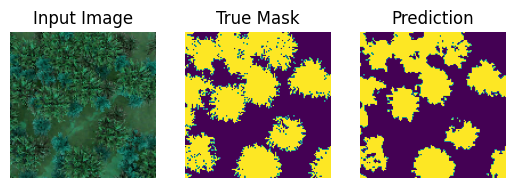

1/1 [==============================] - 0s 138ms/step


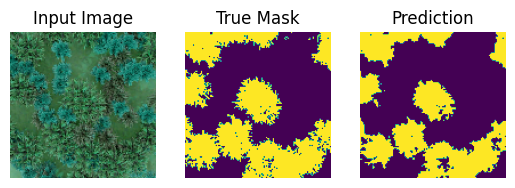

1/1 [==============================] - 0s 120ms/step


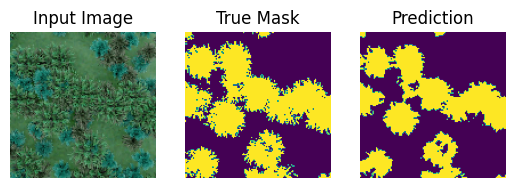

In [19]:
# display predictions on few samples from the validation set
n_images = 3
for _ in range(n_images):
    randint = np.random.randint(0, X_test.shape[0])
    image = X_test[randint][None,:]
    mask = y_test[randint][None,:]

    auto = tf.data.AUTOTUNE
    data = tf.data.Dataset.from_tensor_slices({'image':image, 'segmentation_mask':mask})
    ds = (
      data
      .map(load_image, num_parallel_calls=auto)
      .batch(1)
      .prefetch(auto)
    )
    for sample in ds.take(1):
        images, masks = sample["pixel_values"], sample["labels"]
        masks = tf.expand_dims(masks, -1)

    seg_masks = model.predict(images).logits
    display([
      image[0],
      mask[0],
      create_mask(seg_masks)
    ])

### Comparison of the trained models on test set

In [15]:
# load the trained models and evaluate them
# bigger u-net
best_params = df.iloc[np.argmax(df.val_iou),:]
model_unet = get_unet(
        input_img,
        n_filters = best_params.filters,
        dropout = best_params.dropout,
        batchnorm = True,
        n_classes = 1
      )
model_unet.load_weights(os.path.join(PATH, 'models', 'u_net_tuned'))
adam = Adam(learning_rate=best_params.learning_rate)
model_unet.compile(
    optimizer=adam,
    loss=DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,]
    )
u_net_eval = model_unet.evaluate(X_test, y_test, return_dict=True)

# small u-net
best_params = df.loc[df.filters==8].iloc[np.argmax(df.loc[df.filters==8].val_iou),:]
model_unet_small = get_unet(
        input_img,
        n_filters = best_params.filters,
        dropout = best_params.dropout,
        batchnorm = True,
        n_classes = 1
      )
model_unet_small.load_weights(os.path.join(PATH, 'models', 'u_net_small_tuned'))
adam = Adam(learning_rate=best_params.learning_rate)
model_unet_small.compile(
    optimizer=adam,
    loss=DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,]
    )
u_net_small_eval = model_unet_small.evaluate(X_test, y_test, return_dict=True)

# vgg16 u-net
best_params = df.iloc[np.argmax(df.val_iou),:]
model_vgg = get_pretrained_u_net()
model_vgg.load_weights(os.path.join(PATH, 'models', 'u_net_vgg_tuned'))
adam = Adam(learning_rate=best_params.learning_rate)
model_vgg.compile(
    optimizer=adam,
    loss=DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,]
    )
vgg_eval = model_vgg.evaluate(X_test, y_test, return_dict=True)

25/25 [==============================] - 551s 22s/step - loss: 0.0423 - accuracy: 0.9494 - binary_io_u_2: 0.9031 - get_f1: 0.9446


In [26]:
# segformer
# retrain the best model on all data and save it
from transformers import TFSegformerForSemanticSegmentation

# load the pretrained transformer model and adjust it to our settings
model_checkpoint = "nvidia/segformer-b0-finetuned-ade-512-512"
id2label = {0: "no_tree", 1: "tree"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

K.clear_session()
model_segformer = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
# use the same learning rate as in paper
model_segformer.load_weights(os.path.join(PATH, 'models', 'segformer_tuned'))
lr = 0.00006
adam = tf.keras.optimizers.Adam(learning_rate=lr)
model_segformer.compile(optimizer=adam)

test_pred = model_segformer.predict(test_ds)
testpred_mask = tf.math.argmax(test_pred.logits, axis=1)
testpred_mask = tf.expand_dims(testpred_mask, -1)
test_pred_trans = testpred_mask.numpy()
DiceLoss()(y_test, test_pred_trans)
loss = DiceLoss()(y_test, test_pred_trans).numpy()
f1 = get_f1(y_test, test_pred_trans).numpy()
accuracy = sum(y_test.flatten()==test_pred_trans.flatten())/len(y_test.flatten())
iou = sum(y_test.flatten()*test_pred_trans.flatten())/sum((y_test.flatten()+test_pred_trans.flatten())>0)
segformer_eval = pd.DataFrame(
    [[loss, accuracy, iou, f1]],
    columns=['loss', 'accuracy', 'binary_io_u', 'get_f1'],
    index=['SegFormer']
    )

800/800 [==============================] - 50s 59ms/step


In [35]:
print('Comparison of the models on test set:')
pd.concat([
    pd.DataFrame([list(u_net_eval.values())],  index=['U-Net'], columns=segformer_eval.columns),
    pd.DataFrame([list(u_net_small_eval.values())], index=['U-Net small'], columns=segformer_eval.columns),
    pd.DataFrame([list(vgg_eval.values())], index=['VGG'], columns=segformer_eval.columns),
    segformer_eval
    ], axis=0)

Comparison of the models on test set:


,loss,accuracy,binary_io_u,get_f1
U-Net,0.033411,0.959718,0.921993,0.955807
U-Net small,0.039509,0.952388,0.908465,0.947811
VGG,0.042317,0.949417,0.903054,0.944646
SegFormer,0.110464,0.908245,0.801048,0.889536


In [36]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]

1/1 [==============================] - 0s 152ms/step


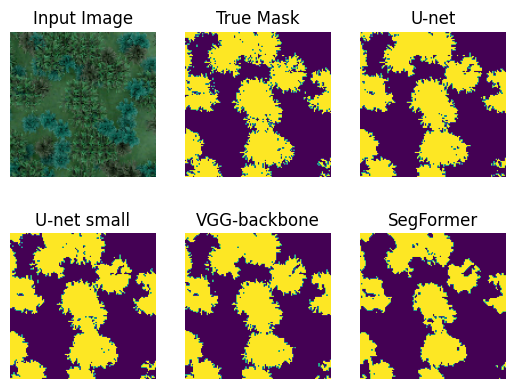

1/1 [==============================] - 0s 72ms/step


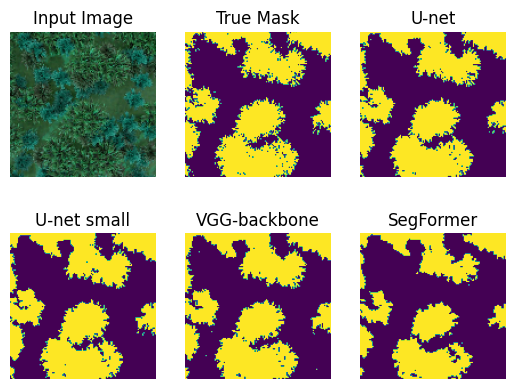

1/1 [==============================] - 0s 149ms/step


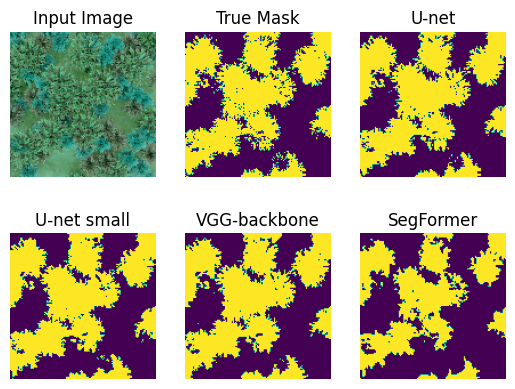

In [40]:
# compare predictions on a sample from the test set
n_images = 3
for _ in range(n_images):
    randint = np.random.randint(0, X_test.shape[0])
    image = X_test[randint][None,:]
    mask = y_test[randint][None,:]

    auto = tf.data.AUTOTUNE
    data = tf.data.Dataset.from_tensor_slices({'image':image, 'segmentation_mask':mask})
    ds = (
      data
      .map(load_image, num_parallel_calls=auto)
      .batch(1)
      .prefetch(auto)
    )

    y_pred_u_net = model_unet.predict(image, verbose=0).round()
    y_pred_u_net_small = model_unet_small.predict(image, verbose=0).round()
    y_pred_vgg = model_vgg.predict(image, verbose=0).round()

    for sample in ds.take(1):
        images, masks = sample["pixel_values"], sample["labels"]
        masks = tf.expand_dims(masks, -1)

    seg_masks = model_segformer.predict(images).logits
    display([
      image[0],
      mask[0],
      y_pred_u_net[0],
      y_pred_u_net_small[0],
      y_pred_vgg[0],
      create_mask(seg_masks)
    ])

### Predictions on unlabelled test set

In [58]:
y_test_no = np.zeros((1000, 128, 128, 1))

In [59]:
test_no_data = tf.data.Dataset.from_tensor_slices({'image':X_test_no, 'segmentation_mask':y_test_no})
auto = tf.data.AUTOTUNE
batch_size = 16

# load the images and apply the transformation

test_no_ds = (
    test_no_data
    .map(load_image, num_parallel_calls=auto)
    .batch(1)
    .prefetch(auto)
)

In [60]:
# segformer
from transformers import TFSegformerForSemanticSegmentation

# load the pretrained transformer model and adjust it to our settings
model_checkpoint = "nvidia/segformer-b0-finetuned-ade-512-512"
id2label = {0: "no_tree", 1: "tree"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

K.clear_session()
model_segformer = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
model_segformer.load_weights(os.path.join(PATH, 'models', 'segformer_tuned'))
lr = 0.00006
adam = tf.keras.optimizers.Adam(learning_rate=lr)
model_segformer.compile(optimizer=adam)

test_pred = model_segformer.predict(test_ds)
testpred_mask = tf.math.argmax(test_pred.logits, axis=1)
testpred_mask = tf.expand_dims(testpred_mask, -1)
test_pred_trans = testpred_mask.numpy()

np.save(os.path.join(PATH, 'assets', 'segformer_predictions.npy'), test_pred_trans)

1000/1000 [==============================] - 47s 46ms/step


In [64]:
# load the trained models and evaluate them
# bigger u-net
best_params = df.iloc[np.argmax(df.val_iou),:]
model_unet = get_unet(
        input_img,
        n_filters = best_params.filters,
        dropout = best_params.dropout,
        batchnorm = True,
        n_classes = 1
      )
model_unet.load_weights(os.path.join(PATH, 'models', 'u_net_tuned'))
adam = Adam(learning_rate=best_params.learning_rate)
model_unet.compile(
    optimizer=adam,
    loss=DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,]
    )
u_net_pred = model_unet.predict(X_test_no)

# small u-net
best_params = df.loc[df.filters==8].iloc[np.argmax(df.loc[df.filters==8].val_iou),:]
model_unet_small = get_unet(
        input_img,
        n_filters = best_params.filters,
        dropout = best_params.dropout,
        batchnorm = True,
        n_classes = 1
      )
model_unet_small.load_weights(os.path.join(PATH, 'models', 'u_net_small_tuned'))
adam = Adam(learning_rate=best_params.learning_rate)
model_unet_small.compile(
    optimizer=adam,
    loss=DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,]
    )
u_net_small_pred = model_unet_small.predict(X_test_no)

# vgg16 u-net
best_params = df.iloc[np.argmax(df.val_iou),:]
model_vgg = get_pretrained_u_net()
model_vgg.load_weights(os.path.join(PATH, 'models', 'u_net_vgg_tuned'))
adam = Adam(learning_rate=best_params.learning_rate)
model_vgg.compile(
    optimizer=adam,
    loss=DiceLoss(),
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(), get_f1,]
    )
vgg_pred = model_vgg.predict(X_test_no)

np.save(os.path.join(PATH, 'assets', 'u_net_predictions.npy'), u_net_pred)
np.save(os.path.join(PATH, 'assets', 'u_net_small_predictions.npy'), u_net_small_pred)
np.save(os.path.join(PATH, 'assets', 'vgg_predictions.npy'), vgg_pred)

32/32 [==============================] - 8s 242ms/step
